In [3]:
pacman::p_load(dplyr,pheatmap,tidyverse,ggplot2,data.table)

In [ ]:
#' Read in file and calc Ehux concentration
#' 
#' @param fcsfile The FCS-formatted output file from the guava
#' @param curr The well we're looking at, in numeric order (for the file parsing)
#' @param rep The replicate to be considered
#' @param strain The strain that we're considering
#' @param currday The date in the experiment
readfcmwell_ehux <- function(fcm,curr,rep,strain,position,currday,sample_size,
                             return_slice=FALSE,
                             flow_rate=0.59,transfer="None") {
    
  t1 = as.POSIXct(trimws(as.character(description(fcm)["$BTIM"])),format="%H:%M:%S")
  t2 = as.POSIXct(trimws(as.character(description(fcm)["$ETIM"])),format="%H:%M:%S")
  timediff = as.numeric(t2 - t1,units="secs")
  fcm <- as.data.frame((exprs(fcm)))
  
  # set to NA/mark for removal if too low
  fcm <- na.omit(fcm) # Remove null values 
  
  # if sample size isn't set to the max number of events, truncate to the first frew
  if(sample_size != 'max'){
    try({fcm.sample <- fcm[sample(length(fcm$SSC.HLin), sample_size),]},
        silent = T)
  }

  # instead of saving all FCM data, we just need to count the Ehux events + get
  # conc, this is unmanageable.
  fcs_slice = fcm %>% dplyr::filter(((FSC.HLin) > 2000) & ((RED.B.HLin) > 2000))
  count_events = nrow(fcs_slice)
  mean_redb = mean(fcs_slice$RED.B.HLin)
  min_redb = min(fcs_slice$RED.B.HLin)
  max_redb = max(fcs_slice$RED.B.HLin)
    
  sd_redb = sd(fcs_slice$RED.B.HLin)
  mean_fsc = mean(fcs_slice$FSC.HLin)
  min_fsc = min(fcs_slice$FSC.HLin)
  max_fsc = max(fcs_slice$FSC.HLin)
  sd_fsc = sd(fcs_slice$FSC.HLin)
  mean_ssc = mean(fcs_slice$SSC.HLin)
  conc_curr = count_events / timediff / 0.59 * 10^3 # in cells/mL
  
  currres = data.frame("Date" = as.character(currday), 
                       "MeanSSC" = mean_ssc, "MeanFSC" = mean_fsc,
                       "MinFSC" = min_fsc,
                       "MaxFSC" = max_fsc,
                       "SDFSC" = sd_fsc,
                       "MeanRedB" = mean_redb,
                       "MinRedB" = min_redb,
                       "MaxRedB" = max_redb,
                       "SDRedB" = sd_redb,
                       "FSC_vals"= paste(fcs_slice$FSC.HLin,collapse=","),
                       "SSC_vals"= paste(fcs_slice$SSC.HLin,collapse=","),
                       "Rep" = rep, 
                       "Strain" = strain, 
                       "Transfer" = transfer,
                       "Position" = as.numeric(position),
                       "ConcCellmL" = conc_curr)
    
  if (return_slice) {
      return(fcs_slice)
  }
  return(currres)
}

readfcmwell_accuri <- function(fcs_dir,date,position,strain,rep,transfer,well_spec) {
    well_spec = read.csv(well_spec)
    well_spec = well_spec %>% dplyr::filter((Position==position)&(Strain==strain)) %>%
        dplyr::arrange(Well)
    curr_well = well_spec$Well[as.numeric(rep)]
    curr_well_name = well_spec$Well[as.numeric(rep)]
    fcm = read.FCS(file.path(fcs_dir,paste0(curr_well,".fcs")),emptyValue = FALSE,
           alter.names=TRUE,truncate_max_range=FALSE)
    total_time = difftime(as.POSIXct(as.character(fcm@description["$ETIM"]),format="%H:%M:%OS"),
                          as.POSIXct(as.character(fcm@description["$BTIM"]),format="%H:%M:%OS"),
                          units="mins")
    fcm_df = as.data.frame(exprs(fcm))
    fcm_df$Date = date
    fcm_df$Well = curr_well_name
    fcm_df$Time = total_time
    fcm_df = fcm_df %>% dplyr::left_join(well_spec, by= "Well")
    
    fcm_conc = fcm_df %>%
        dplyr::mutate(logFSC = log10(FSC.H), logFL3 = log10(FL3.H)) %>%
        dplyr::filter((logFSC > 4.5) & (logFL3 > 4.5)) %>%
        dplyr::group_by(Time, Date, Well, Strain, Position, Temp) %>%
        dplyr::tally() %>%
        dplyr::mutate(ConcCellmL = dplyr::case_when(as.Date(Date,format="%Y-%m-%d") < 
                                                    as.Date("2022-01-13",format="%Y-%m-%d") ~ 
                                                    n / 14 / as.numeric(Time) * 10^3 / 1,
                                                    TRUE ~ 
                                                    n / 35 / as.numeric(Time) * 10^3 / 1))
    
    fcm_means = fcm_df %>%
        dplyr::mutate(logSSC = log10(SSC.H), logFSC = log10(FSC.H), logFL3 = log10(FL3.H)) %>%
        dplyr::filter((logFSC > 4) & (logFL3 > 4.5)) %>%
        dplyr::group_by(Time, Date, Well, Strain, Position, Temp) %>%
        dplyr::summarize(meanFSC = mean(logFSC),meanFSC = mean(logFSC),meanRedB = mean(logFL3),
                         minFSC = min(logFSC),maxFSC = max(logFSC),SDFSC=sd(logFSC),
                         minRedB = min(logFL3),maxRedB = max(logFL3),meanSSC=mean(logSSC),
                         SDRedB = sd(logFL3))
    
    currres = data.frame("Date" = date, 
                       "MeanSSC" = fcm_means$meanSSC,
                       "MeanFSC" = fcm_means$meanFSC,
                       "MinFSC" = fcm_means$minFSC,
                       "MaxFSC" = fcm_means$maxFSC,
                       "SDFSC" = fcm_means$SDFSC,
                       "MeanRedB" = fcm_means$meanRedB,
                       "MinRedB" = fcm_means$minRedB,
                       "MaxRedB" = fcm_means$maxRedB,
                       "SDRedB" = fcm_means$SDRedB,
                       "FSC_vals"= paste(fcm_df$FSC.H,collapse=","),
                       "SSC_vals"= paste(fcm_df$SSC.H,collapse=","),
                       "RedB_vals"= paste(fcm_df$FL3.H,collapse=","),
                       "Rep" = rep, 
                       "Transfer" = transfer,
                       "Strain" = strain, 
                       "Position" = as.numeric(position),
                       "ConcCellmL" = fcm_conc$ConcCellmL)
    return(currres)
}

return_processed_files <- function(input_directory,fcsdir,list_of_files,metadata_file) {
    metadata_file = read.csv(metadata_file)
    print(metadata_file$Well)
    #### Typical parameters #####
    sample.size <- 1e5               # number of events to plot, use "max" for all points
    fsc.ll <- 1                      # FSC lower limit
    ssc.ll <- 1                      # SSC lower limit
    fl1.ll <- 1                      # FL1 lower limit (ex488/em536)
    resultsframe_experiment_2 = data.frame("Date" = c(""), "SSC" = c(0), 
                                           "RedB" = c(0),
                                           "Transfer" = c(""), "Rep" = c(0),
                                           "Strain" = c(0), "Position" = c(0))
    
    for (fcsfile_ctr in fcsfiles) {
      fcsfile = file.path(fcsdir, fcsfile_ctr)
      errored = FALSE
      datasetind = 1
      print(strsplit(fcsfile_ctr,"_")[[1]][2])
      while (!errored) {
        fcm = try(read.FCS(fcsfile,emptyValue = FALSE,
                           alter.names=TRUE,dataset = datasetind,truncate_max_range=FALSE))
        if (class(fcm) == "try-error") {
          errored = TRUE
          break
        }
        well_curr = unlist(strsplit(fcm@description$`GTI$SAMPLEID`,"-"))[1]
        tech_rep = unlist(strsplit(fcm@description$`GTI$SAMPLEID`,"-"))[2]
        if (well_curr %in% metadata_file$Well) {

          metadata = metadata_file[which(metadata_file$Well == well_curr),]

          if (metadata$Position != "Ctrl") {
            transfnumber = as.numeric(as.character(metadata$Rep))
            if (length(transfnumber) == 0) {
              transfnumber = 0
            }
            currres = readfcmwell_ehux(fcm,
                                  datasetind,
                                  rep=as.numeric(transfnumber),
                                  strain = as.numeric(as.character(metadata$Strain)),
                                  position = as.character(metadata$Position),
                                  currday = strsplit(fcsfile_ctr,"_")[[1]][1],
                                  sample_size = sample.size)
            resultsframe_experiment_2 = resultsframe_experiment_2 %>% 
              dplyr::bind_rows(currres %>% dplyr::mutate(TechRep = tech_rep,
                                  File = as.character(fcsfile_ctr),
                                  Date = strsplit(fcsfile_ctr,"_")[[1]][1],
                                  Strain = as.numeric(as.character(metadata$Strain))))
          }
        }
        datasetind = datasetind + 1
      }
    }
    resultsframe_experiment_2 = resultsframe_experiment_2 %>% 
      dplyr::filter(Date != "")
}

get_dataset_ind <- function(fcsfile,well_spec,position,strain,rep) {
    well_spec=read.csv(well_spec)
    errored = FALSE
    datasetind = 1
    while (!errored) {
        fcm = try(read.FCS(fcsfile,emptyValue = FALSE,
                           alter.names=TRUE,dataset = datasetind,truncate_max_range=FALSE))
        if (class(fcm) == "try-error") {
            errored = TRUE
            print("File not found or not readable for FCS file: ")
            print(fcsfile)
            break
        }
        well_curr = unlist(strsplit(fcm@description$`GTI$SAMPLEID`,"-"))[1]
        tech_rep = unlist(strsplit(fcm@description$`GTI$SAMPLEID`,"-"))[2]
        if (well_curr %in% well_spec$Well) {

          metadata = well_spec[which(well_spec$Well == well_curr),]
            
          if ((as.character(metadata$Position)==as.character(position)) & 
              (as.character(metadata$Strain)==as.character(strain))& 
              (as.character(metadata$Rep)==as.character(rep))) {
              return(datasetind)
          }
        }
        datasetind = datasetind + 1
    }
}

In [4]:
## read in master sheet
ehux_master_sheet = read.csv("/vortexfs1/omics/alexander/akrinos/2022-ehux-redux/code/EHUX_Therm_master_GR_29Apr23.csv")
ehux_master_sheet = read.csv("/vortexfs1/omics/alexander/akrinos/2022-ehux-redux/code/Ehux_consol_9May23.csv")

In [5]:
all_fcm<-data.frame(fread("/vortexfs1/omics/alexander/akrinos/2022-ehux-redux/code/all_fcm_24May23.csv"))

In [46]:
separated_rows_ssc = all_fcm %>% #dplyr::filter(GR_Calc_placeholder=="TF") %>%
     tidyr::separate_rows(FSC_vals,SSC_vals,RedB_vals,sep=",")

In [25]:
head(separated_rows_ssc)

V1,Date,MeanSSC,MeanFSC,MinFSC,MaxFSC,SDFSC,MeanRedB,MinRedB,MaxRedB,⋯,SSC_vals,Rep,Strain,Transfer,Position,ConcCellmL,Temperature,GR_Calc_placeholder,TransferDate,RedB_vals
<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<int>,<int>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>
63,9/23/20,1668.065,10757.31,2000.887,31918.92,3288.879,13686.81,2132.448,62084.33,⋯,1410.29858398438,1,371,F,11,132372.9,19.6,TF,,NA
63,9/23/20,1668.065,10757.31,2000.887,31918.92,3288.879,13686.81,2132.448,62084.33,⋯,457.133422851562,1,371,F,11,132372.9,19.6,TF,,NA
63,9/23/20,1668.065,10757.31,2000.887,31918.92,3288.879,13686.81,2132.448,62084.33,⋯,1957.47412109375,1,371,F,11,132372.9,19.6,TF,,NA
63,9/23/20,1668.065,10757.31,2000.887,31918.92,3288.879,13686.81,2132.448,62084.33,⋯,2450.34497070312,1,371,F,11,132372.9,19.6,TF,,NA
63,9/23/20,1668.065,10757.31,2000.887,31918.92,3288.879,13686.81,2132.448,62084.33,⋯,408.089660644531,1,371,F,11,132372.9,19.6,TF,,NA
63,9/23/20,1668.065,10757.31,2000.887,31918.92,3288.879,13686.81,2132.448,62084.33,⋯,127.993659973145,1,371,F,11,132372.9,19.6,TF,,NA


In [ ]:
strain_1=c()
strain_2=c()
p_values=c()
test_stats=c()
for (strain_1_curr in c(914,1516,2090,375,3492,3963,6071,1212)) {
    for (strain_2_curr in c(914,1516,2090,375,3492,3963,6071,1212)) {
        if (strain_1_curr==strain_2_curr) {
            next
        }
        x_values=as.numeric((separated_rows_ssc %>% 
                                   dplyr::filter((log10(as.numeric(FSC_vals)) > 5)) %>%
                                   dplyr::filter(Strain==strain_1_curr) %>%
                                   dplyr::filter(Transfer=="F"))$SSC_vals)
        y_values=as.numeric((separated_rows_ssc %>% 
                                   dplyr::filter((log10(as.numeric(FSC_vals)) > 5)) %>%
                                   dplyr::filter(Strain==strain_2_curr)%>%
                                   dplyr::filter(Transfer=="F"))$SSC_vals)
        if ((length(x_values)==0)|(length(y_values)==0)) {
            next
        }
        t_test_curr = t.test(x_values,
                                   y_values,
                                   alternative="two.sided")
        strain_1=c(strain_1,strain_1_curr)
        strain_2=c(strain_2,strain_2_curr)
        p_values=c(p_values,t_test_curr$p.value)
        test_stats=c(test_stats,t_test_curr$statistic)
    }
}

all_frame_ssc = data.frame("Strain1"=strain_1,
                       "Strain2"=strain_2,
                       "Pvalues"=p_values,
                       "Tstat"=test_stats)


In [53]:
strain_1=c()
strain_2=c()
p_values=c()
test_stats=c()
temps_1=c()
temps_2=c()
unique_temps=unique((separated_rows_ssc %>% dplyr::filter(Strain %in% c(914,1516,2090,375,3492,3963,6071,1212)))$Temperature)
for (strain_1_curr in c(914,1516,2090,375,3492,3963,6071,1212)) {
    for (strain_2_curr in c(914,1516,2090,375,3492,3963,6071,1212)) {
        #if (strain_1_curr==strain_2_curr) {
        #    next
        #}
        unique_temps=unique((separated_rows_ssc %>% dplyr::filter(Strain %in% c(strain_1_curr)))$Temperature)
        unique_temps_2=unique((separated_rows_ssc %>% dplyr::filter(Strain %in% c(strain_2_curr)))$Temperature)
        x_frame=separated_rows_ssc %>% dplyr::filter(GR_Calc_placeholder=="TF") %>%
               dplyr::filter((log10(as.numeric(FSC_vals)) > 4.5)&(log10(as.numeric(RedB_vals))>4.5)) %>%
               dplyr::filter(Strain==strain_1_curr) %>%
               dplyr::filter(Transfer=="F") 
        y_frame=separated_rows_ssc %>% dplyr::filter(GR_Calc_placeholder=="TF") %>%
               dplyr::filter((log10(as.numeric(FSC_vals)) > 4.5)&(log10(as.numeric(RedB_vals))>4.5)) %>%
               dplyr::filter(Strain==strain_2_curr)%>%
               dplyr::filter(Transfer=="F")
        
        for (temp1 in unique_temps) {
            for (temp2 in unique_temps_2) {
                x_values = as.numeric((x_frame %>% dplyr::filter(Temperature==temp1))$FSC_vals)
                y_values = as.numeric((y_frame %>% dplyr::filter(Temperature==temp2))$FSC_vals)
                #x_values=as.numeric((separated_rows_ssc %>% 
                #                           dplyr::filter((log10(as.numeric(FSC_vals)) > 5)) %>%
                #                           dplyr::filter(Strain==strain_1_curr) %>%
                #                           dplyr::filter(Transfer=="F") %>%
                #                           dplyr::filter(Temperature==temp1))$FSC_vals)
                #y_values=as.numeric((separated_rows_ssc %>% 
                #                           dplyr::filter((log10(as.numeric(FSC_vals)) > 5)) %>%
                #                           dplyr::filter(Strain==strain_2_curr)%>%
                #                           dplyr::filter(Transfer=="F")%>%
                #                           dplyr::filter(Temperature==temp2))$FSC_vals)
                if ((length(x_values)==0)|(length(y_values)==0)) {
                    next
                }
                print(paste(as.character(c(strain_1_curr,strain_2_curr,temp1,temp2)),collapse="_"))
                flush.console()
                t_test_curr = t.test(x_values,
                                           y_values,
                                           alternative="two.sided")
                strain_1=c(strain_1,strain_1_curr)
                strain_2=c(strain_2,strain_2_curr)
                p_values=c(p_values,t_test_curr$p.value)
                test_stats=c(test_stats,t_test_curr$statistic)
                temps_1=c(temps_1,temp1)
                temps_2=c(temps_2,temp2)
            }
        }
    }
}

all_frame_fsc = data.frame("Strain1"=strain_1,
                       "Strain2"=strain_2,
                       "Pvalues"=p_values,
                       "Tstat"=test_stats,
                       "Temp1"=temps_1,
                       "Temp2"=temps_2)

[1] "914_914_14.1_14.1"
[1] "914_914_14.1_17.8"
[1] "914_914_14.1_21"
[1] "914_914_14.1_24"
[1] "914_914_14.1_27.1"
[1] "914_914_14.1_29.5"
[1] "914_914_17.8_14.1"
[1] "914_914_17.8_17.8"
[1] "914_914_17.8_21"
[1] "914_914_17.8_24"
[1] "914_914_17.8_27.1"
[1] "914_914_17.8_29.5"
[1] "914_914_21_14.1"
[1] "914_914_21_17.8"
[1] "914_914_21_21"
[1] "914_914_21_24"
[1] "914_914_21_27.1"
[1] "914_914_21_29.5"
[1] "914_914_24_14.1"
[1] "914_914_24_17.8"
[1] "914_914_24_21"
[1] "914_914_24_24"
[1] "914_914_24_27.1"
[1] "914_914_24_29.5"
[1] "914_914_27.1_14.1"
[1] "914_914_27.1_17.8"
[1] "914_914_27.1_21"
[1] "914_914_27.1_24"
[1] "914_914_27.1_27.1"
[1] "914_914_27.1_29.5"
[1] "914_914_29.5_14.1"
[1] "914_914_29.5_17.8"
[1] "914_914_29.5_21"
[1] "914_914_29.5_24"
[1] "914_914_29.5_27.1"
[1] "914_914_29.5_29.5"
[1] "914_1516_14.1_17"
[1] "914_1516_14.1_12"
[1] "914_1516_14.1_20.5"
[1] "914_1516_14.1_18.6"
[1] "914_1516_14.1_25.4"
[1] "914_1516_14.1_27"
[1] "914_1516_14.1_28"
[1] "914_1516_14.

[1] "1516_1516_27_27"
[1] "1516_1516_27_28"
[1] "1516_1516_27_22"
[1] "1516_1516_28_17"
[1] "1516_1516_28_12"
[1] "1516_1516_28_20.5"
[1] "1516_1516_28_18.6"
[1] "1516_1516_28_25.4"
[1] "1516_1516_28_27"
[1] "1516_1516_28_28"
[1] "1516_1516_28_22"
[1] "1516_1516_22_17"
[1] "1516_1516_22_12"
[1] "1516_1516_22_20.5"
[1] "1516_1516_22_18.6"
[1] "1516_1516_22_25.4"
[1] "1516_1516_22_27"
[1] "1516_1516_22_28"
[1] "1516_1516_22_22"
[1] "1516_2090_17_27.5"
[1] "1516_2090_17_25.9"
[1] "1516_2090_17_24.4"
[1] "1516_2090_17_22.9"
[1] "1516_2090_17_21.4"
[1] "1516_2090_17_19.6"
[1] "1516_2090_12_27.5"
[1] "1516_2090_12_25.9"
[1] "1516_2090_12_24.4"
[1] "1516_2090_12_22.9"
[1] "1516_2090_12_21.4"
[1] "1516_2090_12_19.6"
[1] "1516_2090_20.5_27.5"
[1] "1516_2090_20.5_25.9"
[1] "1516_2090_20.5_24.4"
[1] "1516_2090_20.5_22.9"
[1] "1516_2090_20.5_21.4"
[1] "1516_2090_20.5_19.6"
[1] "1516_2090_18.6_27.5"
[1] "1516_2090_18.6_25.9"
[1] "1516_2090_18.6_24.4"
[1] "1516_2090_18.6_22.9"
[1] "1516_2090_18.6_21

[1] "2090_2090_25.9_27.5"
[1] "2090_2090_25.9_25.9"
[1] "2090_2090_25.9_24.4"
[1] "2090_2090_25.9_22.9"
[1] "2090_2090_25.9_21.4"
[1] "2090_2090_25.9_19.6"
[1] "2090_2090_24.4_27.5"
[1] "2090_2090_24.4_25.9"
[1] "2090_2090_24.4_24.4"
[1] "2090_2090_24.4_22.9"
[1] "2090_2090_24.4_21.4"
[1] "2090_2090_24.4_19.6"
[1] "2090_2090_22.9_27.5"
[1] "2090_2090_22.9_25.9"
[1] "2090_2090_22.9_24.4"
[1] "2090_2090_22.9_22.9"
[1] "2090_2090_22.9_21.4"
[1] "2090_2090_22.9_19.6"
[1] "2090_2090_21.4_27.5"
[1] "2090_2090_21.4_25.9"
[1] "2090_2090_21.4_24.4"
[1] "2090_2090_21.4_22.9"
[1] "2090_2090_21.4_21.4"
[1] "2090_2090_21.4_19.6"
[1] "2090_2090_19.6_27.5"
[1] "2090_2090_19.6_25.9"
[1] "2090_2090_19.6_24.4"
[1] "2090_2090_19.6_22.9"
[1] "2090_2090_19.6_21.4"
[1] "2090_2090_19.6_19.6"
[1] "2090_375_27.5_12.8"
[1] "2090_375_27.5_16.7"
[1] "2090_375_27.5_20.1"
[1] "2090_375_27.5_23"
[1] "2090_375_27.5_25.9"
[1] "2090_375_27.5_28.6"
[1] "2090_375_25.9_12.8"
[1] "2090_375_25.9_16.7"
[1] "2090_375_25.9_20.

[1] "375_3492_20.1_15.6"
[1] "375_3492_20.1_19.7"
[1] "375_3492_20.1_22"
[1] "375_3492_20.1_25"
[1] "375_3492_20.1_27.8"
[1] "375_3492_20.1_30.3"
[1] "375_3492_23_15.6"
[1] "375_3492_23_19.7"
[1] "375_3492_23_22"
[1] "375_3492_23_25"
[1] "375_3492_23_27.8"
[1] "375_3492_23_30.3"
[1] "375_3492_25.9_15.6"
[1] "375_3492_25.9_19.7"
[1] "375_3492_25.9_22"
[1] "375_3492_25.9_25"
[1] "375_3492_25.9_27.8"
[1] "375_3492_25.9_30.3"
[1] "375_3492_28.6_15.6"
[1] "375_3492_28.6_19.7"
[1] "375_3492_28.6_22"
[1] "375_3492_28.6_25"
[1] "375_3492_28.6_27.8"
[1] "375_3492_28.6_30.3"
[1] "375_3963_12.8_13"
[1] "375_3963_12.8_18.6"
[1] "375_3963_12.8_10"
[1] "375_3963_12.8_23.8"
[1] "375_3963_12.8_27"
[1] "375_3963_12.8_28"
[1] "375_3963_16.7_13"
[1] "375_3963_16.7_18.6"
[1] "375_3963_16.7_10"
[1] "375_3963_16.7_23.8"
[1] "375_3963_16.7_27"
[1] "375_3963_16.7_28"
[1] "375_3963_20.1_13"
[1] "375_3963_20.1_18.6"
[1] "375_3963_20.1_10"
[1] "375_3963_20.1_23.8"
[1] "375_3963_20.1_27"
[1] "375_3963_20.1_28"
[1

[1] "3492_1212_27.8_23"
[1] "3492_1212_27.8_25.4"
[1] "3492_1212_27.8_27.5"
[1] "3492_1212_30.3_17"
[1] "3492_1212_30.3_20.7"
[1] "3492_1212_30.3_23"
[1] "3492_1212_30.3_25.4"
[1] "3492_1212_30.3_27.5"
[1] "3963_914_13_14.1"
[1] "3963_914_13_17.8"
[1] "3963_914_13_21"
[1] "3963_914_13_24"
[1] "3963_914_13_27.1"
[1] "3963_914_13_29.5"
[1] "3963_914_18.6_14.1"
[1] "3963_914_18.6_17.8"
[1] "3963_914_18.6_21"
[1] "3963_914_18.6_24"
[1] "3963_914_18.6_27.1"
[1] "3963_914_18.6_29.5"
[1] "3963_914_10_14.1"
[1] "3963_914_10_17.8"
[1] "3963_914_10_21"
[1] "3963_914_10_24"
[1] "3963_914_10_27.1"
[1] "3963_914_10_29.5"
[1] "3963_914_23.8_14.1"
[1] "3963_914_23.8_17.8"
[1] "3963_914_23.8_21"
[1] "3963_914_23.8_24"
[1] "3963_914_23.8_27.1"
[1] "3963_914_23.8_29.5"
[1] "3963_914_27_14.1"
[1] "3963_914_27_17.8"
[1] "3963_914_27_21"
[1] "3963_914_27_24"
[1] "3963_914_27_27.1"
[1] "3963_914_27_29.5"
[1] "3963_914_28_14.1"
[1] "3963_914_28_17.8"
[1] "3963_914_28_21"
[1] "3963_914_28_24"
[1] "3963_914_28

[1] "1212_2090_20.7_21.4"
[1] "1212_2090_20.7_19.6"
[1] "1212_2090_23_27.5"
[1] "1212_2090_23_25.9"
[1] "1212_2090_23_24.4"
[1] "1212_2090_23_22.9"
[1] "1212_2090_23_21.4"
[1] "1212_2090_23_19.6"
[1] "1212_2090_25.4_27.5"
[1] "1212_2090_25.4_25.9"
[1] "1212_2090_25.4_24.4"
[1] "1212_2090_25.4_22.9"
[1] "1212_2090_25.4_21.4"
[1] "1212_2090_25.4_19.6"
[1] "1212_2090_27.5_27.5"
[1] "1212_2090_27.5_25.9"
[1] "1212_2090_27.5_24.4"
[1] "1212_2090_27.5_22.9"
[1] "1212_2090_27.5_21.4"
[1] "1212_2090_27.5_19.6"
[1] "1212_375_17_12.8"
[1] "1212_375_17_16.7"
[1] "1212_375_17_20.1"
[1] "1212_375_17_23"
[1] "1212_375_17_25.9"
[1] "1212_375_17_28.6"
[1] "1212_375_20.7_12.8"
[1] "1212_375_20.7_16.7"
[1] "1212_375_20.7_20.1"
[1] "1212_375_20.7_23"
[1] "1212_375_20.7_25.9"
[1] "1212_375_20.7_28.6"
[1] "1212_375_23_12.8"
[1] "1212_375_23_16.7"
[1] "1212_375_23_20.1"
[1] "1212_375_23_23"
[1] "1212_375_23_25.9"
[1] "1212_375_23_28.6"
[1] "1212_375_25.4_12.8"
[1] "1212_375_25.4_16.7"
[1] "1212_375_25.4_20.

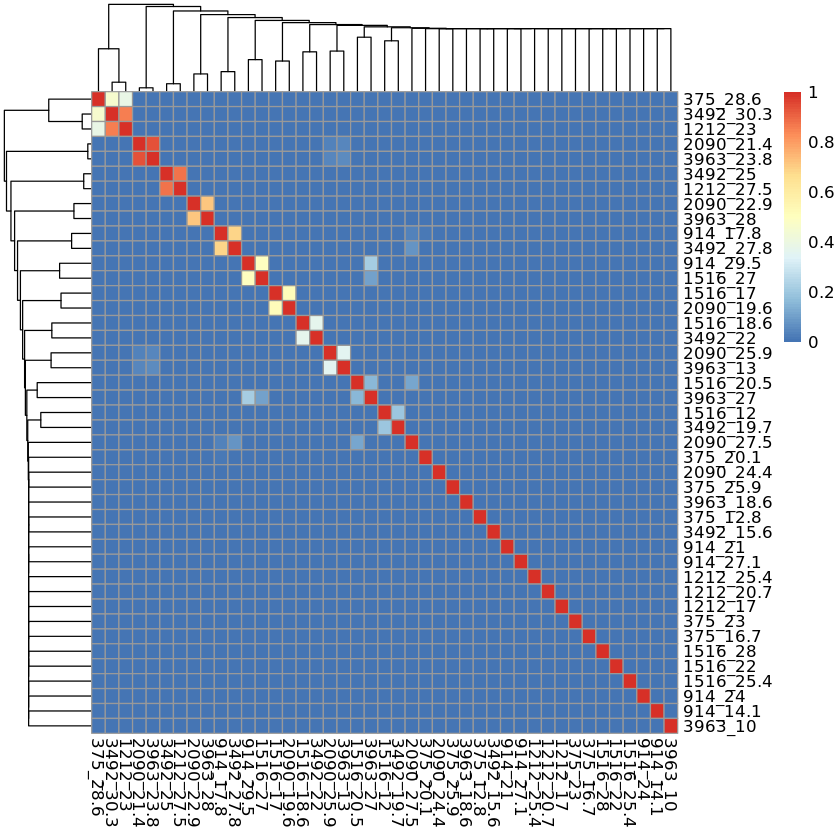

In [55]:
matrix_pvals = all_frame_fsc %>% dplyr::arrange(desc(Pvalues))  %>% 
    dplyr::mutate(StrainTemp1=paste(Strain1,Temp1,sep="_"),
                  StrainTemp2=paste(Strain2,Temp2,sep="_")) %>%
    tidyr::pivot_wider(id_cols = "StrainTemp1",names_from = "StrainTemp2",values_from = "Pvalues")%>% 
    remove_rownames %>% column_to_rownames(var="StrainTemp1")

pacman::p_load(pheatmap)
pheatmap(as.matrix(matrix_pvals))

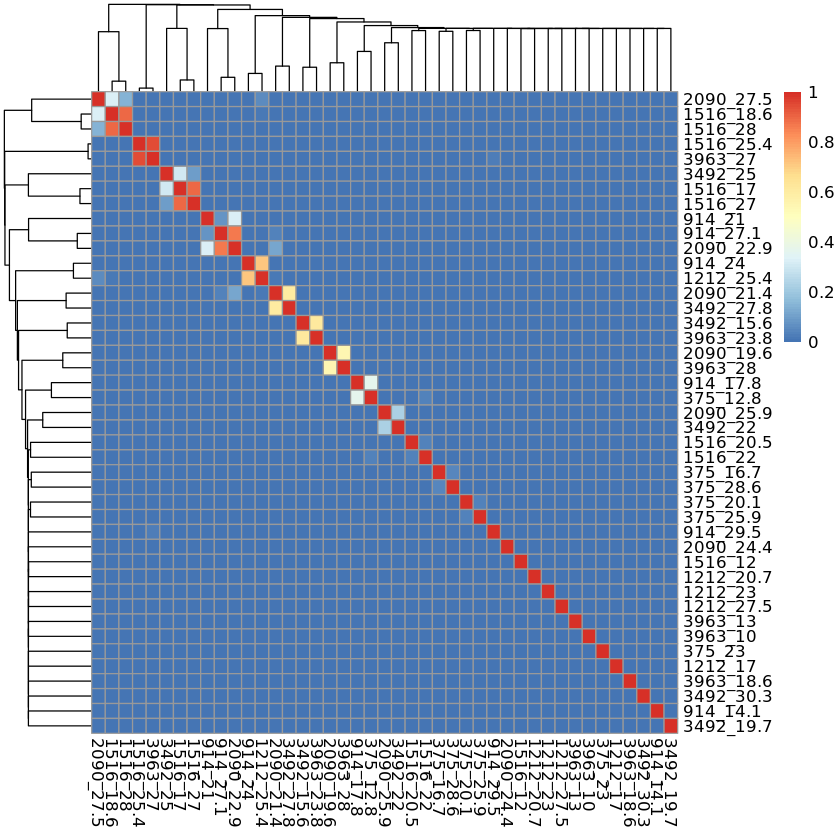

In [12]:
strain_1_curr=3963
select_strain = separated_rows_ssc %>% 
   dplyr::filter((log10(as.numeric(FSC_vals)) > 5)) %>%
   dplyr::filter(Strain==strain_1_curr) %>%
   dplyr::filter(Transfer=="F") %>%
   dplyr::group_by(Temperature) %>%
   dplyr::summarize(meanFSC=mean(as.numeric(FSC_vals),na.rm=T),
                    sdFSC=sd(as.numeric(FSC_vals),na.rm=T))

pacman::p_load(pheatmap)
pheatmap(as.matrix(matrix_pvals))

In [49]:
select_strain = separated_rows_ssc %>% 
   dplyr::filter((log10(as.numeric(FSC_vals)) > 4.5)&(log10(as.numeric(RedB_vals))>4.5)) %>%
   dplyr::filter(Strain==strain_1_curr) %>%
   dplyr::filter(Transfer=="F") %>%
   dplyr::group_by(Temperature,GR_Calc_placeholder,MeanFSC) %>%
   dplyr::summarize(meanFSC=mean(log10(as.numeric(as.character(FSC_vals))),na.rm=T),
                    sdFSC=sd(log10(as.numeric(as.character(FSC_vals))),na.rm=T))

`summarise()` has
grouped output by
'Temperature',
'GR_Calc_placeholder'.
You can override
using the
`.groups`
argument.


`summarise()` has
grouped output by
'Temperature',
'GR_Calc_placeholder',
'MeanFSC'. You
can override
using the
`.groups`
argument.


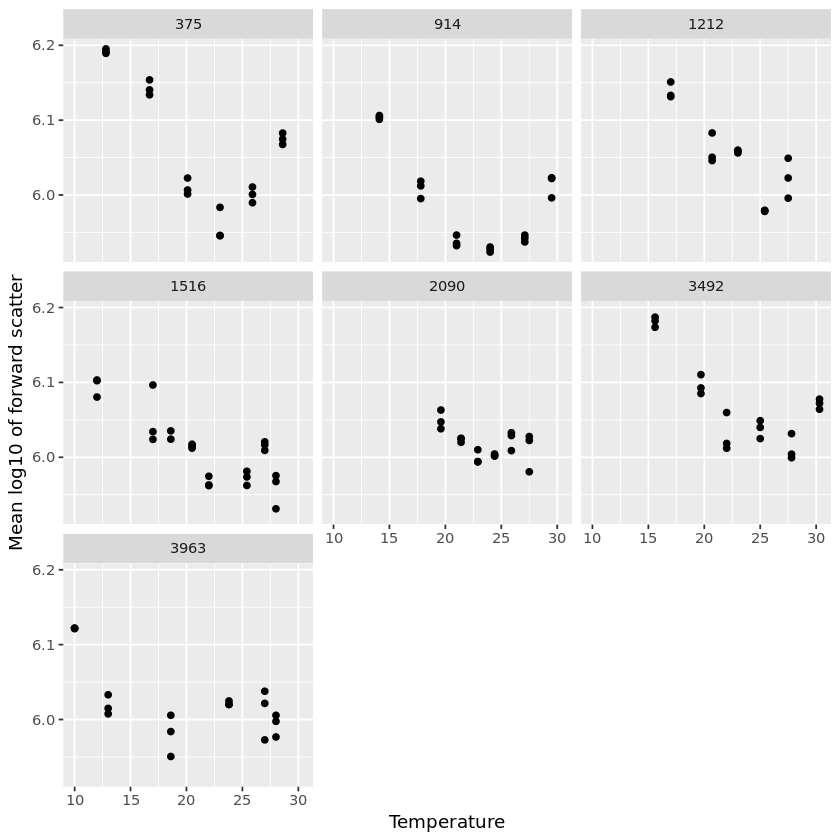

In [60]:
select_strain = separated_rows_ssc %>% dplyr::filter(GR_Calc_placeholder=="TF") %>%
   dplyr::filter((log10(as.numeric(FSC_vals)) > 4.5)&(log10(as.numeric(RedB_vals))>4.5)) %>%
   dplyr::filter(Transfer=="F") %>%
   dplyr::group_by(Temperature,GR_Calc_placeholder,MeanFSC,Strain) %>%
   dplyr::summarize(meanFSC=mean(log10(as.numeric(as.character(FSC_vals))),na.rm=T),
                    sdFSC=sd(log10(as.numeric(as.character(FSC_vals))),na.rm=T))

ggplot(select_strain) + 
    geom_point(aes(x = Temperature, y = meanFSC)) + 
    facet_wrap(~Strain) + ylab("Mean log10 of forward scatter")

`summarise()` has
grouped output by
'Temperature',
'GR_Calc_placeholder',
'MeanFSC'. You
can override
using the
`.groups`
argument.


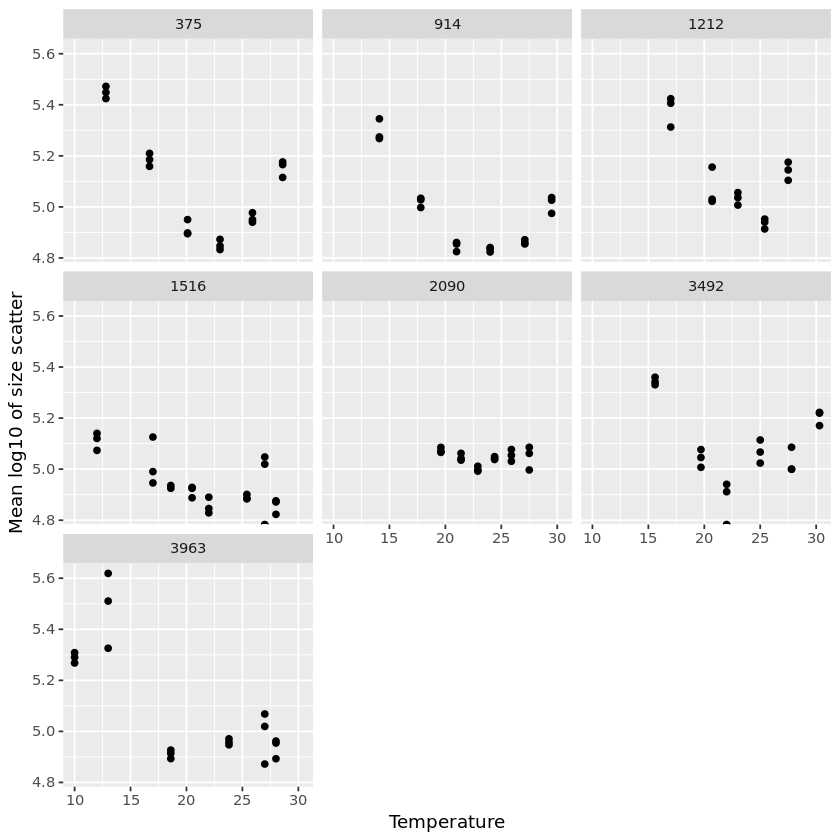

In [61]:
select_strain = separated_rows_ssc %>% dplyr::filter(GR_Calc_placeholder=="TF") %>%
   dplyr::filter((log10(as.numeric(FSC_vals)) > 4.5)&(log10(as.numeric(RedB_vals))>4.5)) %>%
   dplyr::filter(Transfer=="F") %>%
   dplyr::group_by(Temperature,GR_Calc_placeholder,MeanFSC,Strain) %>%
   dplyr::summarize(meanFSC=mean(log10(as.numeric(as.character(FSC_vals))),na.rm=T),
                    sdFSC=sd(log10(as.numeric(as.character(FSC_vals))),na.rm=T),
                   meanSSC=mean(log10(as.numeric(as.character(SSC_vals))),na.rm=T),
                    sdSSC=sd(log10(as.numeric(as.character(SSC_vals))),na.rm=T))

ggplot(select_strain) + 
    geom_point(aes(x = Temperature, y = meanSSC)) + 
    facet_wrap(~Strain) + ylab("Mean log10 of size scatter")

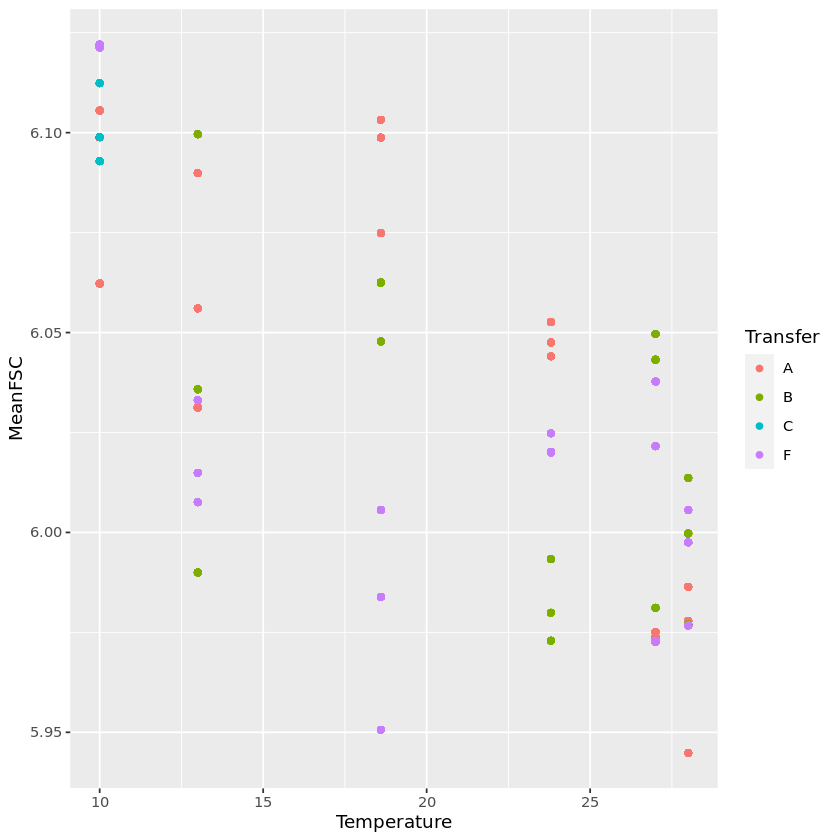

In [22]:
ggplot(separated_rows_ssc %>% 
   dplyr::filter((log10(as.numeric(FSC_vals)) > 5)) %>%
   dplyr::filter(Strain==strain_1_curr)) + 
    geom_point(aes(x = Temperature, y = MeanFSC, color=Transfer))